## Figure 4

Comparing signals in the feature space

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(ggrepel))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure4")
extensions <- c(".png", ".pdf")

### Panel A - Feature heatmaps

In [3]:
consensus_dir <- file.path("..", "1.Data-exploration", "Consensus")

cp_df <- load_consensus_signatures(assay = "cellpainting", data_dir = consensus_dir)
l1000_df <- load_consensus_signatures(assay = "l1000", data_dir = consensus_dir)

In [4]:
# Get correlation of feature spaces
cp_subset_df <- cp_df %>%
    dplyr::filter((Metadata_dose_recode >= 6) | (Metadata_broad_sample == "dmso"))

cp_corr_df <- cp_subset_df %>%
    dplyr::select(starts_with(c("Cells", "Cytoplasm", "Nuclei"))) %>%
    as.matrix() %>%
    Hmisc::rcorr(type = "pearson")

cp_corr_df <- cp_corr_df$r

# L1000
l1000_subset_df <- l1000_df %>%
    dplyr::filter((dose >= 6) | (pert_iname == "dmso"))

l1000_corr_df <- l1000_subset_df %>%
    dplyr::select(ends_with("at")) %>%
    as.matrix() %>%
    Hmisc::rcorr(type = "pearson")

l1000_corr_df <- l1000_corr_df$r

In [5]:
cp_heat_gg <- grid::grid.grabExpr(
    draw(
        Heatmap(
            cp_corr_df,

            show_row_names = FALSE,
            show_column_names = FALSE,

            column_title = "Cell Painting features",

            heatmap_legend_param = list(
                    title = "Pearson\ncorrelation",
                    color_bar = "continuous",
                    col_fun = legend_scale_cols,
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    title_position = "topleft",
                    labels_gp = gpar(fontsize = lgd_label_fontsize),
                    legend_height = unit(3, "cm")
            )
        )
    )
)

In [6]:
l1000_heat_gg <- grid::grid.grabExpr(
    draw(
        Heatmap(
            l1000_corr_df,

            show_row_names = FALSE,
            show_column_names = FALSE,

            column_title = "L1000 features",

            heatmap_legend_param = list(
                    title = "Pearson\ncorrelation",
                    color_bar = "continuous",
                    col_fun = legend_scale_cols,
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    title_position = "topleft",
                    labels_gp = gpar(fontsize = lgd_label_fontsize),
                    legend_height = unit(3, "cm")
            )
        )
    )
)


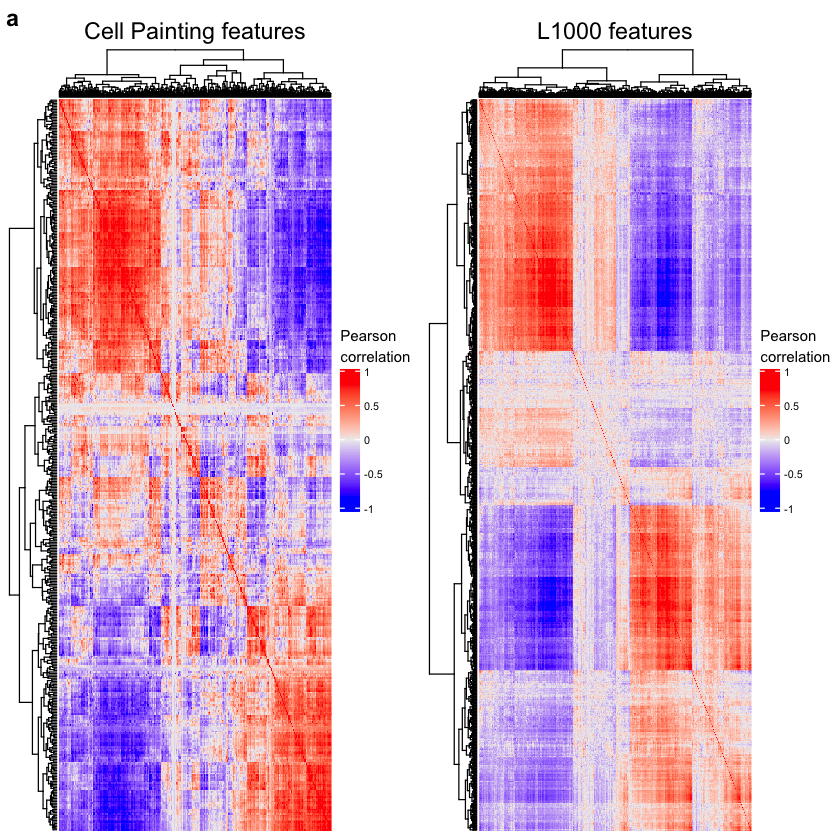

In [7]:
panel_a_gg <- cowplot::plot_grid(
    cp_heat_gg,
    l1000_heat_gg,
    ncol = 2,
    labels = c("a", "")
)

panel_a_gg

### Panel B

In [8]:
# Load PCA explained variance
pca_dir <- file.path("..", "3.clustering-pca", "results")

cp_file <- file.path(pca_dir, "cell_painting", "cp_pca_explained_variance.csv")
l1000_file <- file.path(pca_dir, "L1000", "L1000_pca_explained_variance.csv")

In [9]:
pc_cols <- readr::cols(
    var = readr::col_double(),
    PC = readr::col_character()
)

cp_pca_df <- readr::read_csv(cp_file, col_types = pc_cols) %>% dplyr::mutate(assay = "Cell Painting")
l1000_pca_df <- readr::read_csv(l1000_file, col_types = pc_cols) %>% dplyr::mutate(assay = "L1000")

pca_df <- dplyr::bind_rows(cp_pca_df, l1000_pca_df) %>%
    dplyr::mutate(PC_num = as.numeric(paste(gsub("PC", "", PC)))) %>%
    dplyr::filter(PC_num <= 25)

head(pca_df)

var,PC,assay,PC_num
<dbl>,<chr>,<chr>,<dbl>
24.290942,PC1,Cell Painting,1
4.588631,PC2,Cell Painting,2
3.788078,PC3,Cell Painting,3
2.913764,PC4,Cell Painting,4
2.819691,PC5,Cell Painting,5
2.342608,PC6,Cell Painting,6


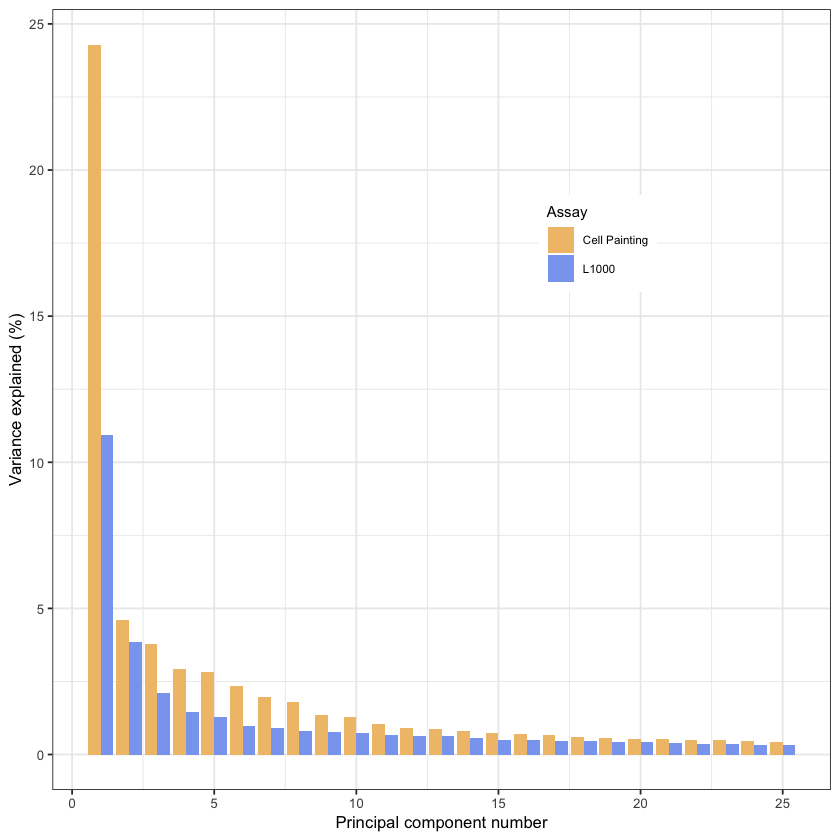

In [10]:
panel_b_gg <- (
    ggplot(pca_df, aes(x = PC_num, y = var, fill = assay))
    + geom_bar(stat = "identity", position = "dodge")
    + figure_theme
    + scale_fill_manual("Assay", values = assay_colors)
    + ylab("Variance explained (%)")
    + xlab("Principal component number")
    + theme(legend.position = c(0.7, 0.7))
)

panel_b_gg

### Panel C

In [11]:
# Load Signature Strength and MAS scores
results_dir <- file.path("..", "1.Data-exploration", "Profiles_level4")

cell_painting_file <- file.path(results_dir, "cell_painting", "cellpainting_lvl4_cpd_replicate_datasets", "cp_all_scores.csv")
l1000_file <- file.path(results_dir, "L1000", "L1000_lvl4_cpd_replicate_datasets", "L1000_all_scores.csv")

ss_cols <- readr::cols(
    .default = readr::col_double(),
    cpd = readr::col_character(),
    dose = readr::col_character()
)

cp_ss_df <- readr::read_csv(cell_painting_file, col_types = ss_cols)
l1000_ss_df <- readr::read_csv(l1000_file, col_types = ss_cols)

# Load MOA info
moa_file <- file.path(results_dir, "aligned_moa_CP_L1000.csv")

moa_cols <- readr::cols(
    Metadata_broad_sample = readr::col_character(),
    broad_id = readr::col_character(),
    pert_iname = readr::col_character(),
    moa = readr::col_character()
)

moa_df <- readr::read_csv(moa_file, col_types = moa_cols)

# Load data on whether compound passed threshold
sig_file <- file.path("data", "significant_compounds_by_threshold_both_assays.tsv.gz")

sig_cols <- readr::cols(
    compound = readr::col_character(),
    dose = readr::col_character(),
    median_replicate_score_cellpainting = readr::col_double(),
    median_replicate_score_l1000 = readr::col_double(),
    pass_cellpainting_thresh = readr::col_logical(),
    pass_l1000_thresh = readr::col_logical(),
    pass_both = readr::col_logical(),
    cell_painting_num_reproducible = readr::col_double(),
    l1000_num_reproducible = readr::col_double(),
    total_reproducible = readr::col_double()
)

significant_compounds_df <- readr::read_tsv(sig_file, col_types = sig_cols)

head(significant_compounds_df)

compound,dose,median_replicate_score_cellpainting,median_replicate_score_l1000,pass_cellpainting_thresh,pass_l1000_thresh,pass_both,cell_painting_num_reproducible,l1000_num_reproducible,total_reproducible
<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
17-hydroxyprogesterone-caproate,0.04 uM,0.060654847,0.02473778,FALSE,FALSE,FALSE,2,1,3
2-iminobiotin,0.04 uM,0.042700097,-0.13369283,FALSE,FALSE,FALSE,0,1,1
3-amino-benzamide,0.04 uM,0.104272757,0.05195868,TRUE,FALSE,FALSE,1,0,1
3-deazaadenosine,0.04 uM,0.010217481,0.06596661,FALSE,FALSE,FALSE,1,0,1
ABT-737,0.04 uM,0.004469596,0.01640021,FALSE,FALSE,FALSE,4,0,4
AICA-ribonucleotide,0.04 uM,0.035320734,-0.00970293,FALSE,FALSE,FALSE,1,0,1


In [12]:
ss_df <- cp_ss_df %>%
    dplyr::inner_join(l1000_ss_df, by = c("cpd", "dose"), suffix = c("_cellpainting", "_l1000")) %>%
    dplyr::left_join(moa_df, by = c("cpd" = "pert_iname")) %>%
    dplyr::left_join(significant_compounds_df, by = c("cpd" = "compound", "dose" = "dose"))

output_file <- file.path("data", "compound_activity_full.tsv")
ss_df %>% readr::write_tsv(output_file)

print(dim(ss_df))
head(ss_df, 2)

[1] 7992   19


cpd,dose,replicate_correlation_cellpainting,signature_strength_cellpainting,MAS,replicate_correlation_l1000,signature_strength_l1000,TAS,Metadata_broad_sample,broad_id,moa,median_replicate_score_cellpainting,median_replicate_score_l1000,pass_cellpainting_thresh,pass_l1000_thresh,pass_both,cell_painting_num_reproducible,l1000_num_reproducible,total_reproducible
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
17-hydroxyprogesterone-caproate,0.04 uM,0.06065485,338.6,0.1601253,0.02473778,263.0000,0.08156217,BRD-A29731977-001-04-5,BRD-A29731977,Progesterone receptor agonist,0.06065485,0.02473778,FALSE,FALSE,FALSE,2,1,3
2-iminobiotin,0.04 uM,0.04270010,334.2,0.1334755,-0.13369283,242.3333,0.00000000,BRD-K07954936-001-01-3,BRD-K07954936,Nitric oxide synthase inhibitor,0.04270010,-0.13369283,FALSE,FALSE,FALSE,0,1,1


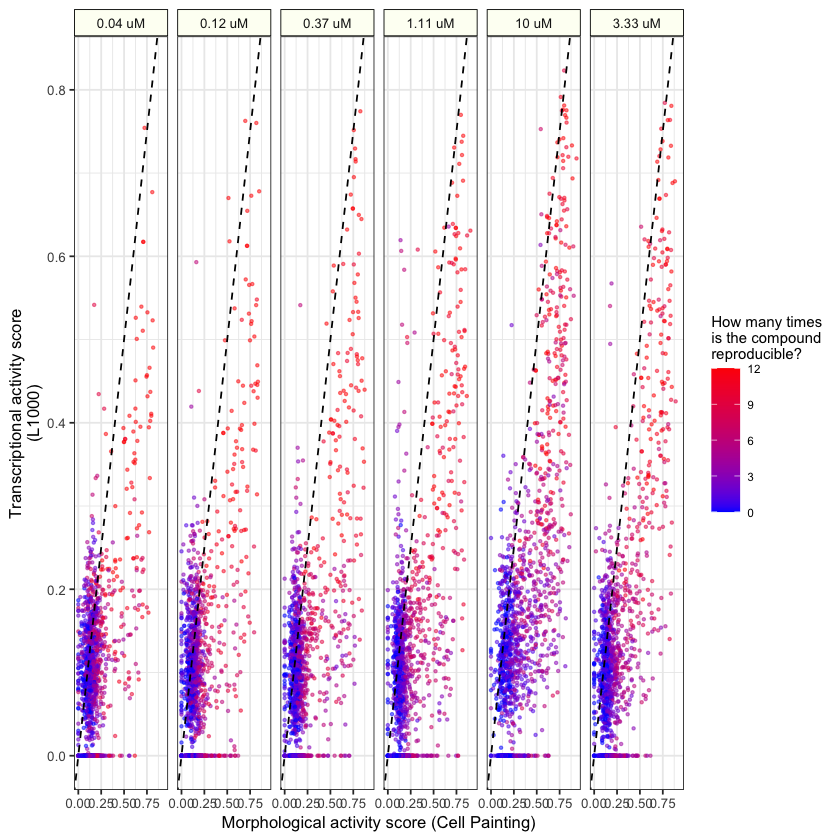

In [13]:
panel_c_gg <- (
    ggplot(ss_df, aes(x = MAS, y = TAS))
    + geom_point(aes(color = total_reproducible), size = 0.6, alpha = 0.5)
    + facet_grid("~dose")
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + scale_color_gradient("How many times\nis the compound\nreproducible?", low = "blue", high = "red")
    + xlab("Morphological activity score (Cell Painting)")
    + ylab("Transcriptional activity score\n(L1000)")
)

panel_c_gg

In [14]:
top_diff_activity_df <- ss_df %>%
    dplyr::filter(
        cell_painting_num_reproducible > 3,
        l1000_num_reproducible > 3
    ) %>%
    dplyr::group_by(cpd) %>%
    dplyr::summarize(mas_mean = mean(MAS), tas_mean = mean(TAS), cpd_count = sum(total_reproducible)) %>%
    dplyr::mutate(mas_tas_dff = mas_mean - tas_mean) %>%
    dplyr::arrange(desc(mas_tas_dff))

output_file <- file.path("data", "highmas_lowtas_compounds.tsv")
top_diff_activity_df %>% readr::write_tsv(output_file)

head(top_diff_activity_df)

cpd,mas_mean,tas_mean,cpd_count,mas_tas_dff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
alisertib,0.7093481,0.2001189,60,0.5092291
dasatinib,0.7255265,0.2476898,60,0.4778368
aphidicolin,0.7069061,0.2673556,60,0.4395504
at13387,0.7433610,0.3197050,60,0.4236560
sta-5326,0.7084493,0.2868042,66,0.4216451
combretastatin-a-4,0.7568159,0.3466371,66,0.4101788


In [15]:
color_logic <- top_diff_activity_df$mas_tas_dff > 0.40

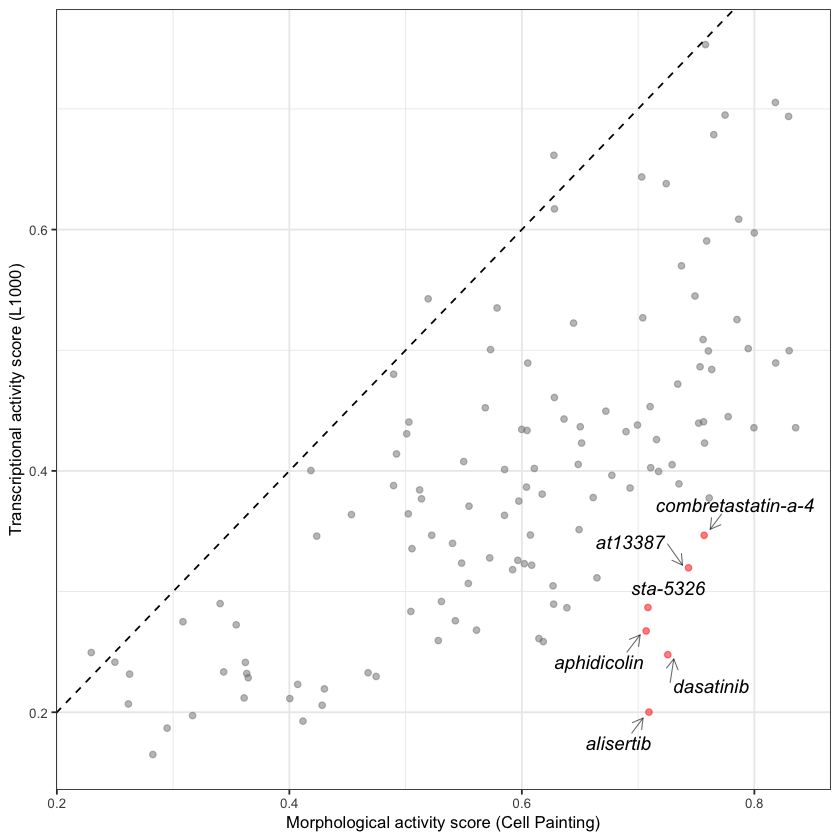

In [16]:
panel_d_gg <- (
    ggplot(top_diff_activity_df, aes(x = mas_mean, y = tas_mean))
    + geom_point(color = ifelse(color_logic, "red", "grey50"), alpha = 0.5)
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + xlab("Morphological activity score (Cell Painting)")
    + ylab("Transcriptional activity score (L1000)")
    + geom_text_repel(
        data = subset(top_diff_activity_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.3,
        segment.alpha = 0.6,
        size = 4,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.5,
        aes(
            x = mas_mean,
            y = tas_mean,
            label = cpd,
        )
    )
)

panel_d_gg

## Panel E

In [17]:
# Load Signature Strength and MAS scores
ora_results_dir <- file.path("..", "5.Gene-analysis", "results")

ora_results_file <- file.path(ora_results_dir, "ora_compound_results.tsv")

ora_cols <- readr::cols(
    geneSet = readr::col_character(),
    description = readr::col_character(),
    link = readr::col_character(),
    size = readr::col_double(),
    overlap = readr::col_double(),
    expect = readr::col_double(),
    enrichmentRatio = readr::col_double(),
    pValue = readr::col_double(),
    FDR = readr::col_double(),
    overlapId = readr::col_character(),
    database = readr::col_character(),
    userId = readr::col_character(),
    compound = readr::col_character()
)

ora_df <- readr::read_tsv(ora_results_file, col_types = ora_cols)

In [18]:
moa_targets <- c(
    "alisertib" = "Alisertib",
    "dasatinib" = "Dasatinib",
    "aphidicolin" = "Aphidicolin",
    "at13387" = "at13387",
    "sta-5326" = "sta-5326",
    "combretastatin-a-4" = "Combretastatin-a-4"
)

moa_colors <- c(
    "alisertib" = "#E6898F",
    "dasatinib" = "#9C55DF",
    "aphidicolin" = "#F0700A",
    "at13387" = "#D3EB5A",
    "sta-5326" = "#34EB62",
    "combretastatin-a-4" = "#01E3E6"
)

# Obtained by taking the top enrichment score for the top three compounds
top_geneSet_selections <- c(
    "GO:0006695",
    "GO:0009267",
    "GO:0044272"
)

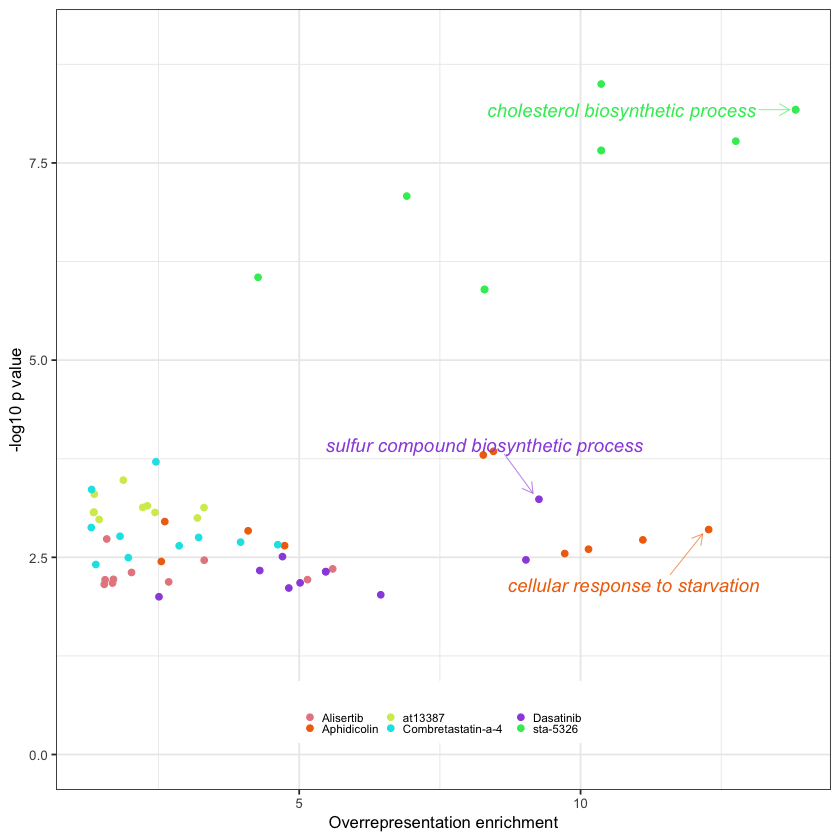

In [19]:
panel_e_gg <- (
    ggplot(ora_df, aes(x = enrichmentRatio, y = -log10(pValue), color = compound))
    + geom_point()
    + ggrepel::geom_text_repel(
        data = ora_df %>% dplyr::filter(geneSet %in% !!top_geneSet_selections),
        aes(label = description),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.3,
        segment.alpha = 0.6,
        size = 4,
        fontface = "italic",
        box.padding = 1.5,
        point.padding = 0.5,
        show.legend = FALSE
    )
    + figure_theme
    + ylim(c(0, 9))
    + scale_color_manual("", labels = moa_targets, values = moa_colors)
    + xlab("Overrepresentation enrichment")
    + ylab("-log10 p value")
    + theme(legend.position = c(0.5, .1), legend.key.size = unit(0.2, "cm"))
    + guides(color = guide_legend(nrow = 2))
)

panel_e_gg

## Merge panels together

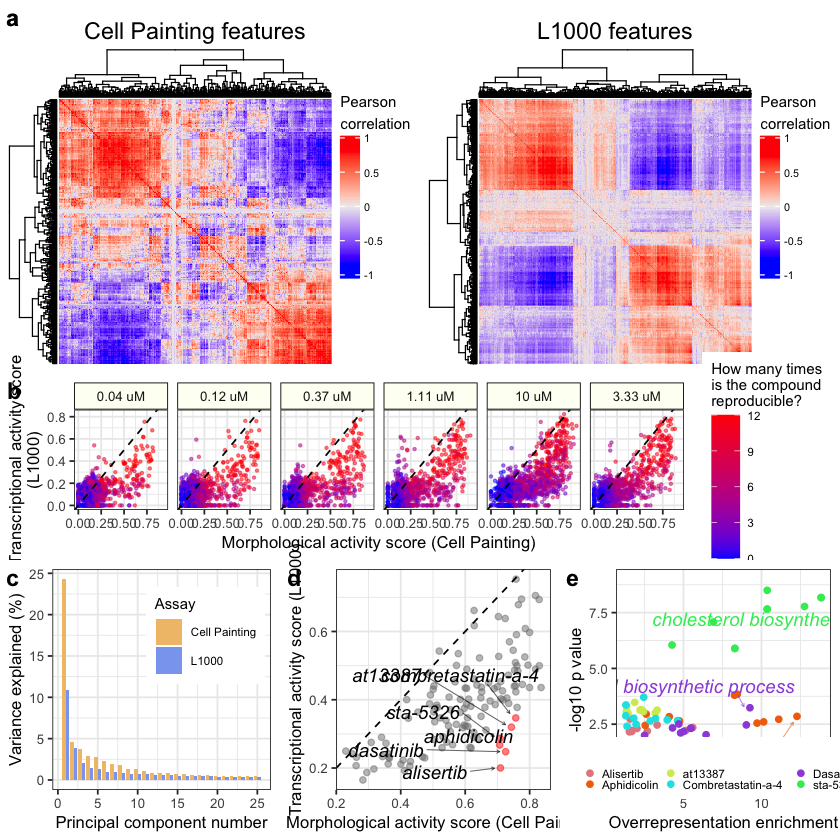

In [20]:
figure_4_gg <- cowplot::plot_grid(
    panel_a_gg,
    panel_c_gg,
    cowplot::plot_grid(
        panel_b_gg,
        panel_d_gg,
        panel_e_gg,
        ncol = 3,
        labels = c("c", "d", "e")
    ),
    nrow = 3,
    labels = c("a", "b", ""),
    rel_heights = c(1, 0.5, 0.75)
)

figure_4_gg

In [21]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, figure_4_gg, base_width = 11, base_height = 11, dpi = 500)
}